In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

Data shapes


/project/vitelli/jonathan/REDO_fruitfly/src/atlas_processing/windowed_radon.py:300: RuntimeWarning: divide by zero encountered in true_divide
  line_weights = 1/(2*np.sqrt(e_len**2-(delta)**2))


Sqh:  (50, 236, 200, 2, 2)
Cad:  (50, 236, 200)
Vel:  (50, 236, 200, 2)
Coordinates shapes
XX:  (50, 236, 200) Range [3.22966, 455.701] um
YY:  (50, 236, 200) Range [3.22657, 536.891] um
TT:  (50, 236, 200) Range [-10, 39] min
(2360000, 1) (2360000, 1) (2360000, 1)
(2360000, 2, 2) (2360000, 1) (2360000, 2)
(100000, 1) (100000, 1) (100000, 1)
(100000, 2, 2) (100000, 1) (100000, 2)


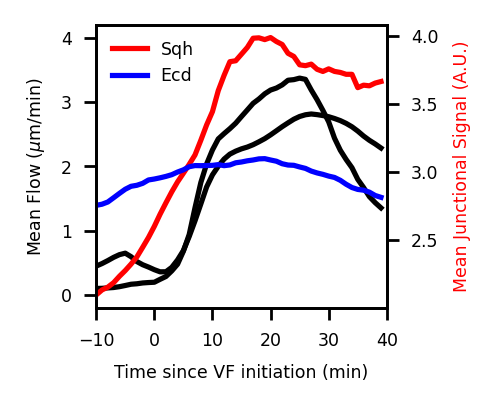

In [2]:
plt.rcParams['font.size'] = 5

loaddir = '../Public/WT/ECad-GFP/ensemble/'
cad = np.load(os.path.join(loaddir, 'cyt2D.npy'), mmap_mode='r')
cad_vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')

loaddir = '../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
sqh = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')
vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')
t = np.load(os.path.join(loaddir, 't.npy'), mmap_mode='r')
y = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
x = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')
              
    
sqh = sqh * 3e1
cad = cad * 1.5e0
    
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(1.5, 1.5))
ax2 = ax.twinx()
ax.plot(t, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax.plot(t, np.linalg.norm(cad_vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax2.plot(t, np.linalg.norm(sqh, axis=(1, 2)).mean(axis=(1, 2)), 
         color='red', label='Sqh')
ax2.plot(t, cad.mean(axis=(1, 2)), 
         color='blue', label='Ecd')
ax2.legend(framealpha=0)

ax.set_ylim([-0.2, 4.2])
ax.set_xlim([-10, 40])
#ax2.set_yticks([80, 100, 120])
ax.set_yticks([0, 1, 2, 3, 4])

ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax2.set_ylabel('Mean Junctional Signal (A.U.)', color='red')
ax.set_xlabel('Time since VF initiation (min)')

print('Data shapes')

sqh = sqh.transpose(0, 3, 4, 1, 2)
cad = cad.transpose(0, 1, 2)

from scipy.ndimage import gaussian_filter
from atlas_processing.anisotropy_detection import cell_size
cad = np.stack([
    gaussian_filter(cad[i], sigma=cell_size) for i in range(cad.shape[0])])

vel = vel.transpose(0, 2, 3, 1)

print('Sqh: ', sqh.shape)
print('Cad: ', cad.shape)
print('Vel: ', vel.shape)

nAP = x.shape[1]
nDV = y.shape[0]
nTP = t.shape[0]

XX = np.broadcast_to(x[None], (nTP, nDV, nAP))
YY = np.broadcast_to(y[None], (nTP, nDV, nAP))
TT = np.broadcast_to(t[:, None, None], (nTP, nDV, nAP))

print('Coordinates shapes')
print('XX: ', XX.shape, 'Range [%g, %g] um' % (XX.min(), XX.max()))
print('YY: ', YY.shape, 'Range [%g, %g] um' % (YY.min(), YY.max()))
print('TT: ', TT.shape, 'Range [%g, %g] min' % (TT.min(), TT.max()))

lower_bound = np.array([TT.min(), YY.min(), XX.min()])
upper_bound = np.array([TT.max(), YY.max(), XX.max()])

t = TT.flatten()[:, None]
y = YY.flatten()[:, None]
x = XX.flatten()[:, None]

sqh_train = sqh.reshape([-1, *sqh.shape[3:]])
cad_train = cad.reshape([-1, 1])
vel_train = vel.reshape([-1, *vel.shape[3:]])

print(t.shape, y.shape, x.shape)
print(sqh_train.shape, cad_train.shape, vel_train.shape)

N_train = 100000
idx = np.random.choice(nAP*nDV*nTP, N_train, replace=False)

x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]

sqh_train = sqh_train[idx, :]
cad_train = cad_train[idx, :]
vel_train = vel_train[idx, :]

print(t_train.shape, y_train.shape, x_train.shape)
print(sqh_train.shape, cad_train.shape, vel_train.shape)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

from run_ClosedLoopPINN import *
        
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ClosedLoopPINN(
    t_train, y_train, x_train,
    sqh_train, cad_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

model.training_step()
model.print()

Iteration 0		1.000 grad^2 v - grad p = -0.000 div(m)
	D_t m = -(1 - 1 s) m + (1 - 0 s) m Tr(E) + (1 - 1 s) Tr(m) Gamma^{DV} + (1 - 1 s) Tr(m) m


In [13]:
from utils.plot_utils import *

beta = 1e2
dirs = 'version_02202022'
#dirs = 'version_03232023'
#dirs = 'version_03282023'
dirs = 'version_04222023'
beta = 1e1
model.load_state_dict(torch.load(
    os.path.join(dirs, 'pinn_closed_loop_beta=%.0e.ckpt' % beta), map_location='cpu'))
with torch.no_grad():
    model.print()
    sqh, vel, dor = model(
        torch.from_numpy(t).float().to(device),
        torch.from_numpy(y).float().to(device),
        torch.from_numpy(x).float().to(device),
    )
    sqh = sqh.cpu().numpy()
    vel = vel.cpu().numpy()
    dor = dor.cpu().numpy()
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
    sqh_pred = sqh.reshape([nTP, nDV, nAP, 2, 2]).transpose(0, 3, 4, 1, 2)
    vel_pred = vel.reshape([nTP, nDV, nAP, 2]).transpose(0, 3, 1, 2)
    dor_pred = dor.reshape([nTP, nDV, nAP])
    
    print(dor_pred.min(), dor_pred.max())
    
N=6
fig, ax = plt.subplots(3, N, dpi=200, figsize=(N,3))
dt = min(10, sqh_pred.shape[0] // N)
for i in range(N):
    ax[0, i].set_title('t = %d'% times[i*dt])
    plot_tensor2D(ax[0, i], sqh_pred[i*dt], cmap='inferno')
    plot_vector2D(ax[1, i], vel_pred[i*dt])
    color_2D(ax[2, i], dor_pred[i*dt], cmap='viridis')
    
    for j in range(3):
        ax[j, i].set_ylim([dv_min, dv_max])
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Flow')
ax[2, 0].set_ylabel('Dorsal source')

RuntimeError: Error(s) in loading state_dict for ClosedLoopPINN:
	size mismatch for model.14.weight: copying a param with shape torch.Size([8, 100]) from checkpoint, the shape in current model is torch.Size([7, 100]).
	size mismatch for model.14.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([7]).

Iteration 0		1.000 grad^2 v - grad p = -0.000 div(m)
	D_t m = -(0.989 - 0.937 s) m + (0.615 - 0.411 s) m Tr(E) + (0.982 - 0.914 s) Tr(m) Gamma^{DV} + (1.01 - 0.932 s) Tr(m) m
1.0780022 1.0793468


Text(0, 0.5, 'Dorsal source')

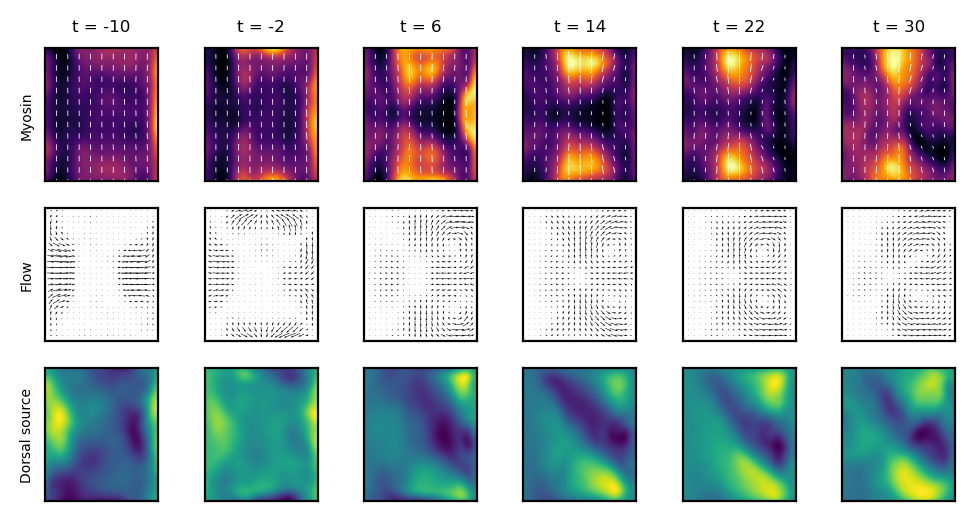

In [11]:
from utils.plot_utils import *

beta = 1e2
dirs = 'version_02202022'
dirs = 'version_03232023'
dirs = 'version_03282023'
dirs = 'version_04222023'
dirs = './'
beta = 1e-1
model.load_state_dict(torch.load(
    os.path.join(dirs, 'pinn_closed_loop_beta=%.0e.ckpt' % beta), map_location='cpu'))
with torch.no_grad():
    model.print()
    sqh, vel, dor = model(
        torch.from_numpy(t).float().to(device),
        torch.from_numpy(y).float().to(device),
        torch.from_numpy(x).float().to(device),
    )
    sqh = sqh.cpu().numpy()
    vel = vel.cpu().numpy()
    dor = dor.cpu().numpy()
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
    sqh_pred = sqh.reshape([nTP, nDV, nAP, 2, 2]).transpose(0, 3, 4, 1, 2)
    vel_pred = vel.reshape([nTP, nDV, nAP, 2]).transpose(0, 3, 1, 2)
    dor_pred = dor.reshape([nTP, nDV, nAP])
    
    print(dor_pred.min(), dor_pred.max())
    
N=6
fig, ax = plt.subplots(3, N, dpi=200, figsize=(N,3))
dt = min(10, sqh_pred.shape[0] // N)
for i in range(N):
    ax[0, i].set_title('t = %d'% times[i*dt])
    plot_tensor2D(ax[0, i], sqh_pred[i*dt], cmap='inferno')
    plot_vector2D(ax[1, i], vel_pred[i*dt])
    color_2D(ax[2, i], dor_pred[i*dt], cmap='viridis')
    
    for j in range(3):
        ax[j, i].set_ylim([dv_min, dv_max])
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Flow')
ax[2, 0].set_ylabel('Dorsal source')

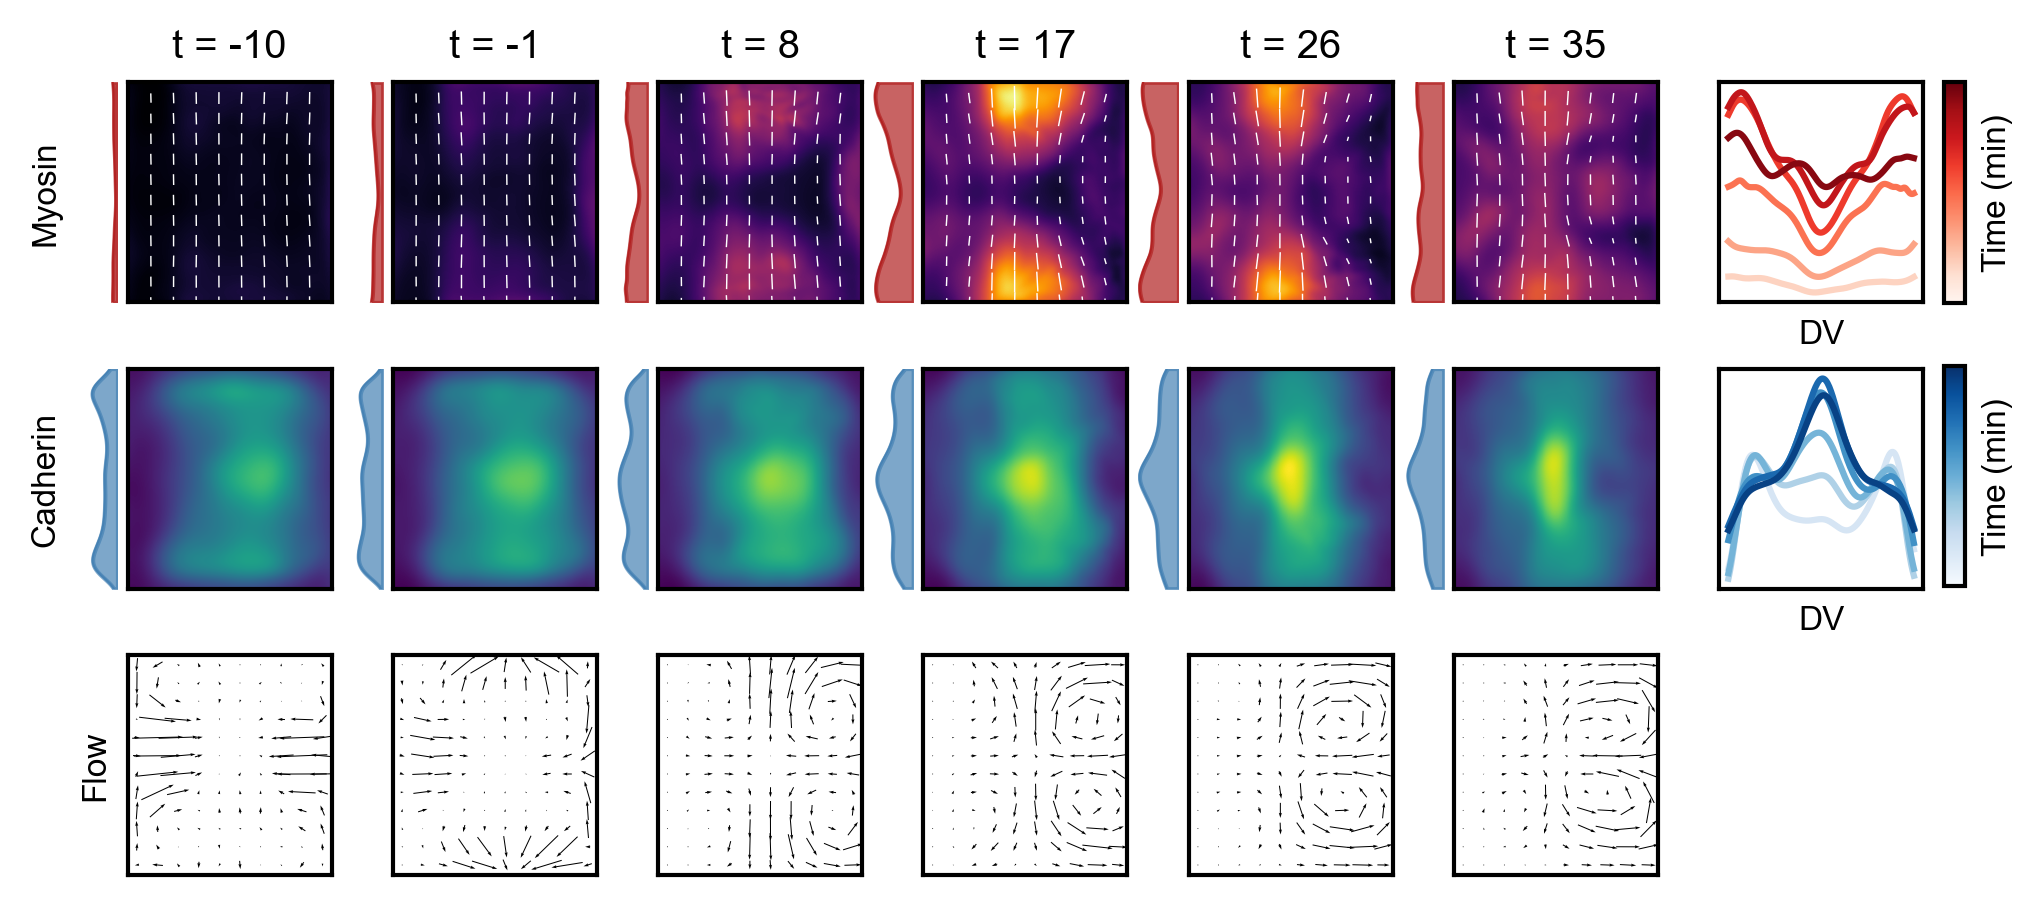

In [12]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['image.origin'] = 'lower'

def plot_with_cuts(ax, z,
                   image_cmap='inferno', 
                   vmin=0, vmax=1,
                   cut_cmap='Greys', 
                   cut_color='tab:red'):
    
    try:
        plot_tensor2D(ax, z, cmap=image_cmap, vmin=vmin, vmax=vmax)
    except:
        color_2D(ax, z, cmap=image_cmap, vmin=vmin, vmax=vmax)
    
    znorm = np.linalg.norm(z.reshape([-1, *z.shape[-2:]]), axis=0)
    base = np.ones_like(znorm)
    base[np.isnan(znorm)] = 0
    znorm = np.nan_to_num(znorm)
        
    N0, N1 = 20, 80
    cut_Y = np.sum(znorm[:, N0:N1], axis=1) / np.sum(base[:, N0:N1], axis=1)
    return cut_Y
    
def plot(m, c, v, t):
    N = 6
    dt = (len(m)-1) // (N-1)

    fig1, ax1 = plt.subplots(3, N+1, figsize=(6+1, 3.5), dpi=300)

    #Boundary crop
    model = pk.load(open('../Public/WT/ECad-GFP/decomposition_models/cyt_SVDPipeline.pkl', 'rb'))
    #model = pk.load(open('Public/WT/ECad-GFP/decomposition_models/cyt_SVDPipeline_PMG_CF.pkl', 'rb'))
    ys, xs = np.where(model['masker'].mask_!=0) 
    mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]  

    mnorm = np.linalg.norm(m[mask], axis=(1, 2))[..., :-20]
    mmin = np.min(mnorm)# + 0.5 * np.std(mnorm)
    mmax = np.max(mnorm)#mmin + 7 * np.std(mnorm)#np.max(mnorm)

    cmin = np.min(c[mask])
    cmax = np.max(c[mask])

    def apply_mask(x0, mask, model=model):
        x = x0.copy()
        x[..., ~model['masker'].mask_] = np.nan
        return x[mask]

    cut_cad = []
    cut_sqh = []
    
    for i in range(N):
        ax1[0, i].set_title('t = %d' % (t[dt*i]))

        s1 = plot_with_cuts(ax1[0, i], apply_mask(m[dt*i], mask), 
                       cut_color='firebrick', cut_cmap='Reds', image_cmap='inferno',
                       vmin=mmin, vmax=mmax)    
        c1 = plot_with_cuts(ax1[1, i], apply_mask(c[dt*i], mask),
                       cut_color='steelblue', cut_cmap='Blues', image_cmap='viridis',
                       vmin=cmin, vmax=cmax)
        cut_cad.append(c1)
        cut_sqh.append(s1)
        y = np.linspace(*ax1[0, i].get_ylim(), len(s1))
    
        sqh_color=plt.get_cmap('Reds')((t[dt*i] + 20)/ (np.max(t) + 20))
        cad_color=plt.get_cmap('Blues')((t[dt*i] + 20)/ (np.max(t) + 20))

        ax1[0, -1].plot(y, s1, color=sqh_color)
        ax1[0, -1].set(xticks=[], yticks=[], xlabel='DV')    
        ax1[1, -1].plot(y, c1, color=cad_color)
        ax1[1, -1].set(xticks=[], yticks=[], xlabel='DV')    

        plot_vector2D(ax1[2, i], v[dt*i], skip=20)
        ax1[2, -1].set_visible(False)
    
    for i in range(N):
        cuts = [cut_sqh[i], cut_cad[i]]
        axes = ax1[:2, i]
        colors = ['firebrick', 'steelblue']
        for cut, ax, color, ax2 in zip(cuts, axes, colors, ax1[:2, -1]):
            y = np.linspace(*ax.get_ylim(), len(cut))

            ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
            ax_Y.plot(cut, y, color=color, lw=0.5)
            ax_Y.fill_betweenx(y, np.ones_like(cut)*ax2.get_ylim()[0], cut,
                               color=color, alpha=0.7)
    
            ax_Y.set(xticks=[], yticks=[])
            ax_Y.set_xlim(ax2.get_ylim())
            ax_Y.invert_xaxis()
            ax_Y.axis('off')


    lp=16
    ax1[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax1[1, 0].set_ylabel('Cadherin', labelpad=lp)
    ax1[2, 0].set_ylabel('Flow')

    from matplotlib.colors import Normalize
    norm = Normalize(vmin=-20, vmax=np.max(t))
    fig1.subplots_adjust(right=0.98, wspace=0.3, hspace=0.3)


    cax = fig1.add_axes([0.99, 0.67, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=cax, label='Time (min)', ticks=[])
    cax = fig1.add_axes([0.99, 0.4, 0.01, 0.21])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'),
                 cax=cax, label='Time (min)', ticks=[])


    for a in ax1.flatten():
        a.set_aspect('auto')

plot(sqh_pred, cad_pred, vel_pred, np.arange(-10, 40))